In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import torch

DATASET_NAME = 'CIFAR10'    # CIFAR10, CIFAR100
DATASET_TYPE = 'custom'   # baseline, custom
REWEIGHT = True
EPOCHS = 200
BATCH_SIZE = 128
ENABLE_TPU = True
LEARNING_RATE = 0.1   # 0.15(default), 0.1
MANUAL_SEED = 1

# CIFAR-10-C
if DATASET_NAME=='CIFAR10':
    dataset_dir = '/kaggle/input/cifar-c'
    print(os.listdir(dataset_dir))
    # Define the path to the subdirectory
    sub_dir = os.path.join(dataset_dir, 'CIFAR-10-C')
    # List contents of the subdirectory
    print(os.listdir(sub_dir))
elif DATASET_NAME=='CIFAR100':
    # CIFAR-100-C
    dataset_dir = '/kaggle/input/cifar-100-c'
    print(os.listdir(dataset_dir))
else:
    raise ValueError(f'Dataset {DATASET_NAME} not supported')
    

print(f'Hyperparameters:\n\tDataset: {DATASET_NAME}\n\tType: {DATASET_TYPE}\n\tEpochs: {EPOCHS}\n\tTPU Enabled: {ENABLE_TPU}')

['CIFAR-10-C']
['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']
Hyperparameters:
	Dataset: CIFAR10
	Type: custom
	Epochs: 200
	TPU Enabled: True


In [2]:
!pip install torchmetrics scikit-image
!git clone https://github.com/EkagraGupta/MasterArbeit.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/926.4 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━ 512.0/926.4 kB 15.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 14.4 MB/s eta 0:00:00


     ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/14.9 MB 35.1 MB/s eta 0:00:01

     ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/14.9 MB 41.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/14.9 MB 52.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━ 13.5/14.9 MB 104.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 14.9/14.9 MB 113.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 59.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.2/228.2 kB 16.4 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 20.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Cloning into 'MasterArbeit'...


remote: Enumerating objects: 3870, done.


remote: Counting objects: 100% (684/684), done.


remote: Compressing objects: 100% (304/304), done.


remote: Total 3870 (delta 406), reused 650 (delta 380), pack-reused 3186 (from 1)
Receiving objects: 100% (3870/3870), 1.13 GiB | 1.64 MiB/s, done.


Resolving deltas: 100% (2161/2161), done.


Updating files: 100% (337/337), done.


In [3]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(MANUAL_SEED)

In [4]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = ENABLE_TPU

if tpu == True:
    print('TPU is Enabled')
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = BATCH_SIZE

print(f'Loading {DATASET_NAME}...\n')
if DATASET_NAME=='CIFAR10':
#     Use CIFAR-10 dataset for training
    num_classes = 10    # CIFAR-10
    baseline_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)

    # Use CIFAR-10 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
elif DATASET_NAME=='CIFAR100':
    # # Use CIFAR-100 dataset for training
    num_classes = 100   # CIFAR-100
    baseline_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)

    # Use CIFAR-100 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
    
%cd /kaggle/working/MasterArbeit
!git checkout add-randomerasing
from augment_dataset import create_transforms, load_data
# from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=False, custom=True, dataset_name=DATASET_NAME)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation, dataset_name=DATASET_NAME)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
%cd

classes = baseline_trainset.classes


TPU is Enabled


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


E0000 00:00:1733307833.935022      77 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:483


Loading CIFAR10...



  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 32768/170498071 [00:00<09:21, 303682.16it/s]

  0%|          | 65536/170498071 [00:00<09:10, 309448.59it/s]

  0%|          | 98304/170498071 [00:00<09:14, 307226.05it/s]

  0%|          | 229376/170498071 [00:00<04:14, 668148.70it/s]

  0%|          | 458752/170498071 [00:00<02:21, 1198362.94it/s]

  1%|          | 917504/170498071 [00:00<01:15, 2243271.33it/s]

  1%|          | 1835008/170498071 [00:00<00:39, 4299023.36it/s]

  2%|▏         | 3702784/170498071 [00:00<00:19, 8429760.04it/s]

  4%|▍         | 6782976/170498071 [00:00<00:11, 14552508.84it/s]

  6%|▌         | 9764864/170498071 [00:01<00:08, 18443624.50it/s]

  8%|▊         | 12877824/170498071 [00:01<00:07, 21602342.47it/s]

  9%|▉         | 15990784/170498071 [00:01<00:06, 23797297.79it/s]

 11%|█         | 19070976/170498071 [00:01<00:05, 25243208.85it/s]

 13%|█▎        | 22183936/170498071 [00:01<00:05, 26269276.22it/s]

 15%|█▍        | 25264128/170498071 [00:01<00:05, 27055477.13it/s]

 17%|█▋        | 28344320/170498071 [00:01<00:05, 27539284.18it/s]

 18%|█▊        | 31457280/170498071 [00:01<00:04, 27936747.42it/s]

 20%|██        | 34570240/170498071 [00:01<00:04, 28127911.53it/s]

 22%|██▏       | 37683200/170498071 [00:02<00:04, 28452538.25it/s]

 24%|██▍       | 40796160/170498071 [00:02<00:04, 28596896.21it/s]

 26%|██▌       | 43679744/170498071 [00:02<00:04, 28401119.74it/s]

 27%|██▋       | 46530560/170498071 [00:02<00:04, 27942805.45it/s]

 29%|██▉       | 49348608/170498071 [00:02<00:04, 27311640.67it/s]

 31%|███       | 52101120/170498071 [00:02<00:04, 26801456.09it/s]

 32%|███▏      | 54820864/170498071 [00:02<00:04, 26343434.08it/s]

 34%|███▍      | 57835520/170498071 [00:02<00:04, 26587765.24it/s]

 36%|███▌      | 60882944/170498071 [00:02<00:03, 27654094.65it/s]

 37%|███▋      | 63668224/170498071 [00:03<00:03, 27634263.35it/s]

 39%|███▉      | 66453504/170498071 [00:03<00:03, 26828052.45it/s]

 41%|████      | 69173248/170498071 [00:03<00:03, 26536941.75it/s]

 42%|████▏     | 71860224/170498071 [00:03<00:03, 26343039.58it/s]

 44%|████▍     | 74940416/170498071 [00:03<00:03, 26091080.18it/s]

 46%|████▌     | 77987840/170498071 [00:03<00:03, 26481854.65it/s]

 47%|████▋     | 80904192/170498071 [00:03<00:03, 26481076.72it/s]

 49%|████▉     | 84017152/170498071 [00:03<00:03, 27120080.18it/s]

 51%|█████     | 87097344/170498071 [00:03<00:03, 27508133.71it/s]

 53%|█████▎    | 90210304/170498071 [00:03<00:02, 27852145.31it/s]

 55%|█████▍    | 93290496/170498071 [00:04<00:02, 28071979.72it/s]

 57%|█████▋    | 96403456/170498071 [00:04<00:02, 28324356.42it/s]

 58%|█████▊    | 99516416/170498071 [00:04<00:02, 28457285.64it/s]

 60%|██████    | 102596608/170498071 [00:04<00:02, 28505397.22it/s]

 62%|██████▏   | 105709568/170498071 [00:04<00:02, 28620162.03it/s]

 64%|██████▍   | 108789760/170498071 [00:04<00:02, 28315134.71it/s]

 66%|██████▌   | 111902720/170498071 [00:04<00:02, 28467428.00it/s]

 67%|██████▋   | 115015680/170498071 [00:04<00:01, 28548827.48it/s]

 69%|██████▉   | 118095872/170498071 [00:04<00:01, 28580739.36it/s]

 71%|███████   | 120979456/170498071 [00:05<00:01, 28351892.78it/s]

 73%|███████▎  | 123830272/170498071 [00:05<00:01, 27429577.05it/s]

 74%|███████▍  | 126582784/170498071 [00:05<00:01, 27066901.99it/s]

 76%|███████▌  | 129302528/170498071 [00:05<00:01, 26371375.90it/s]

 77%|███████▋  | 131989504/170498071 [00:05<00:01, 26453815.99it/s]

 79%|███████▉  | 134840320/170498071 [00:05<00:01, 26971926.38it/s]

 81%|████████  | 137560064/170498071 [00:05<00:01, 26693089.36it/s]

 82%|████████▏ | 140247040/170498071 [00:05<00:01, 25776117.00it/s]

 84%|████████▍ | 142835712/170498071 [00:05<00:01, 25537303.03it/s]

 85%|████████▌ | 145752064/170498071 [00:06<00:00, 25730727.35it/s]

 87%|████████▋ | 148701184/170498071 [00:06<00:00, 25902460.52it/s]

 89%|████████▉ | 151814144/170498071 [00:06<00:00, 26422235.15it/s]

 91%|█████████ | 154861568/170498071 [00:06<00:00, 26675822.59it/s]

 93%|█████████▎| 157876224/170498071 [00:06<00:00, 26836801.88it/s]

 94%|█████████▍| 160858112/170498071 [00:06<00:00, 26809064.77it/s]

 96%|█████████▌| 163905536/170498071 [00:06<00:00, 26614809.32it/s]

 98%|█████████▊| 166887424/170498071 [00:06<00:00, 26508986.01it/s]

100%|█████████▉| 169738240/170498071 [00:06<00:00, 26399197.00it/s]

100%|██████████| 170498071/170498071 [00:06<00:00, 24554652.65it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified


/kaggle/working/MasterArbeit


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


branch 'add-randomerasing' set up to track 'origin/add-randomerasing'.


Switched to a new branch 'add-randomerasing'


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 32768/170498071 [00:00<09:18, 305366.97it/s]

  0%|          | 65536/170498071 [00:00<09:33, 297062.31it/s]

  0%|          | 98304/170498071 [00:00<09:11, 308983.53it/s]

  0%|          | 229376/170498071 [00:00<04:14, 669256.99it/s]

  0%|          | 458752/170498071 [00:00<02:21, 1201356.49it/s]

  1%|          | 917504/170498071 [00:00<01:15, 2242624.55it/s]

  1%|          | 1835008/170498071 [00:00<00:39, 4306994.23it/s]

  2%|▏         | 3702784/170498071 [00:00<00:19, 8484546.62it/s]

  4%|▍         | 6815744/170498071 [00:00<00:11, 14842800.23it/s]

  6%|▌         | 9895936/170498071 [00:01<00:08, 19067912.64it/s]

  8%|▊         | 12812288/170498071 [00:01<00:07, 21929903.77it/s]

  9%|▉         | 15368192/170498071 [00:01<00:06, 22819811.12it/s]

 11%|█         | 18382848/170498071 [00:01<00:06, 24078866.65it/s]

 13%|█▎        | 21331968/170498071 [00:01<00:05, 24895499.27it/s]

 14%|█▍        | 24444928/170498071 [00:01<00:05, 25569608.02it/s]

 16%|█▌        | 27394048/170498071 [00:01<00:05, 25908909.89it/s]

 18%|█▊        | 30343168/170498071 [00:01<00:05, 26264111.23it/s]

 20%|█▉        | 33390592/170498071 [00:01<00:05, 26701107.75it/s]

 21%|██▏       | 36438016/170498071 [00:02<00:04, 26946787.03it/s]

 23%|██▎       | 39485440/170498071 [00:02<00:04, 27017413.65it/s]

 25%|██▍       | 42467328/170498071 [00:02<00:04, 27118366.06it/s]

 27%|██▋       | 45547520/170498071 [00:02<00:04, 27549090.64it/s]

 29%|██▊       | 48660480/170498071 [00:02<00:04, 27993972.80it/s]

 30%|███       | 51740672/170498071 [00:02<00:04, 28222858.33it/s]

 32%|███▏      | 54853632/170498071 [00:02<00:04, 28455834.73it/s]

 34%|███▍      | 57933824/170498071 [00:02<00:03, 28498429.41it/s]

 36%|███▌      | 61046784/170498071 [00:02<00:03, 28586678.55it/s]

 37%|███▋      | 63930368/170498071 [00:03<00:03, 28643031.69it/s]

 39%|███▉      | 66813952/170498071 [00:03<00:03, 28109805.24it/s]

 41%|████      | 69632000/170498071 [00:03<00:03, 27526488.24it/s]

 42%|████▏     | 72417280/170498071 [00:03<00:03, 27283275.83it/s]

 44%|████▍     | 75431936/170498071 [00:03<00:03, 27896679.64it/s]

 46%|████▌     | 78479360/170498071 [00:03<00:03, 28626773.35it/s]

 48%|████▊     | 81592320/170498071 [00:03<00:03, 28767887.36it/s]

 50%|████▉     | 84705280/170498071 [00:03<00:02, 28858394.98it/s]

 51%|█████▏    | 87752704/170498071 [00:03<00:02, 28754011.52it/s]

 53%|█████▎    | 90865664/170498071 [00:03<00:02, 28842155.88it/s]

 55%|█████▌    | 93913088/170498071 [00:04<00:02, 29287999.55it/s]

 57%|█████▋    | 96862208/170498071 [00:04<00:02, 28678045.01it/s]

 59%|█████▊    | 99745792/170498071 [00:04<00:02, 28029371.33it/s]

 60%|██████    | 102563840/170498071 [00:04<00:02, 27403092.58it/s]

 62%|██████▏   | 105381888/170498071 [00:04<00:02, 27328997.12it/s]

 64%|██████▎   | 108462080/170498071 [00:04<00:02, 28084779.03it/s]

 65%|██████▌   | 111607808/170498071 [00:04<00:02, 28190414.69it/s]

 67%|██████▋   | 114688000/170498071 [00:04<00:01, 28580547.56it/s]

 69%|██████▉   | 117833728/170498071 [00:04<00:01, 28742399.00it/s]

 71%|███████   | 120913920/170498071 [00:05<00:01, 28840142.29it/s]

 73%|███████▎  | 123830272/170498071 [00:05<00:01, 28913281.23it/s]

 74%|███████▍  | 126746624/170498071 [00:05<00:01, 28360782.52it/s]

 76%|███████▌  | 129597440/170498071 [00:05<00:01, 27748502.15it/s]

 78%|███████▊  | 132415488/170498071 [00:05<00:01, 27715515.55it/s]

 79%|███████▉  | 135430144/170498071 [00:05<00:01, 28352433.04it/s]

 81%|████████  | 138379264/170498071 [00:05<00:01, 28408594.53it/s]

 83%|████████▎ | 141393920/170498071 [00:05<00:01, 28695253.44it/s]

 85%|████████▍ | 144506880/170498071 [00:05<00:00, 28814827.49it/s]

 86%|████████▋ | 147423232/170498071 [00:05<00:00, 28901334.20it/s]

 88%|████████▊ | 150339584/170498071 [00:06<00:00, 28028165.28it/s]

 90%|████████▉ | 153157632/170498071 [00:06<00:00, 27498269.18it/s]

 92%|█████████▏| 156073984/170498071 [00:06<00:00, 27539225.02it/s]

 93%|█████████▎| 159154176/170498071 [00:06<00:00, 27927945.24it/s]

 95%|█████████▌| 162267136/170498071 [00:06<00:00, 28284633.39it/s]

 97%|█████████▋| 165380096/170498071 [00:06<00:00, 28539619.31it/s]

 99%|█████████▉| 168525824/170498071 [00:06<00:00, 28485600.71it/s]

100%|██████████| 170498071/170498071 [00:06<00:00, 25053255.14it/s]

Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 32768/170498071 [00:00<09:07, 311283.09it/s]

  0%|          | 65536/170498071 [00:00<09:15, 306753.65it/s]

  0%|          | 98304/170498071 [00:00<09:11, 308875.14it/s]

  0%|          | 229376/170498071 [00:00<04:13, 670406.75it/s]

  0%|          | 458752/170498071 [00:00<02:21, 1204725.97it/s]

  1%|          | 917504/170498071 [00:00<01:15, 2252550.81it/s]

  1%|          | 1835008/170498071 [00:00<00:38, 4327285.77it/s]

  2%|▏         | 3702784/170498071 [00:00<00:19, 8500782.00it/s]

  4%|▍         | 6815744/170498071 [00:00<00:10, 14954713.74it/s]

  6%|▌         | 9928704/170498071 [00:01<00:08, 19252502.52it/s]

  8%|▊         | 13008896/170498071 [00:01<00:07, 22245021.87it/s]

  9%|▉         | 16121856/170498071 [00:01<00:06, 24206857.79it/s]

 11%|█▏        | 19202048/170498071 [00:01<00:05, 25621165.12it/s]

 13%|█▎        | 22282240/170498071 [00:01<00:05, 26465396.25it/s]

 15%|█▍        | 24936448/170498071 [00:01<00:05, 26007352.62it/s]

 16%|█▌        | 27557888/170498071 [00:01<00:05, 25302860.55it/s]

 18%|█▊        | 30277632/170498071 [00:01<00:05, 25474339.07it/s]

 19%|█▉        | 32833536/170498071 [00:01<00:05, 25242264.30it/s]

 21%|██        | 35389440/170498071 [00:02<00:05, 25089949.20it/s]

 22%|██▏       | 38109184/170498071 [00:02<00:05, 25659588.00it/s]

 24%|██▍       | 40697856/170498071 [00:02<00:05, 25572974.00it/s]

 25%|██▌       | 43352064/170498071 [00:02<00:05, 25410623.58it/s]

 27%|██▋       | 45907968/170498071 [00:02<00:04, 25062899.42it/s]

 29%|██▊       | 48791552/170498071 [00:02<00:04, 26128038.43it/s]

 30%|███       | 51412992/170498071 [00:02<00:04, 24522183.76it/s]

 32%|███▏      | 54099968/170498071 [00:02<00:04, 25117422.69it/s]

 33%|███▎      | 56655872/170498071 [00:02<00:04, 25125912.72it/s]

 35%|███▍      | 59211776/170498071 [00:02<00:04, 25158589.83it/s]

 36%|███▋      | 61898752/170498071 [00:03<00:04, 25550836.58it/s]

 38%|███▊      | 64815104/170498071 [00:03<00:03, 26595168.23it/s]

 40%|███▉      | 67502080/170498071 [00:03<00:03, 25930306.75it/s]

 41%|████      | 70189056/170498071 [00:03<00:03, 26161500.03it/s]

 43%|████▎     | 72843264/170498071 [00:03<00:03, 24915315.35it/s]

 44%|████▍     | 75399168/170498071 [00:03<00:03, 24985223.62it/s]

 46%|████▌     | 78151680/170498071 [00:03<00:03, 25620377.24it/s]

 47%|████▋     | 80871424/170498071 [00:03<00:03, 26062331.43it/s]

 49%|████▉     | 83492864/170498071 [00:03<00:03, 25496806.04it/s]

 50%|█████     | 86081536/170498071 [00:04<00:03, 24819555.83it/s]

 52%|█████▏    | 88571904/170498071 [00:04<00:03, 24650702.98it/s]

 53%|█████▎    | 91193344/170498071 [00:04<00:03, 24969392.95it/s]

 55%|█████▌    | 93782016/170498071 [00:04<00:03, 25226942.46it/s]

 57%|█████▋    | 96436224/170498071 [00:04<00:02, 25479284.56it/s]

 58%|█████▊    | 99188736/170498071 [00:04<00:02, 26070842.01it/s]

 60%|█████▉    | 101810176/170498071 [00:04<00:02, 25480097.15it/s]

 61%|██████    | 104398848/170498071 [00:04<00:02, 25419273.24it/s]

 63%|██████▎   | 107020288/170498071 [00:04<00:02, 25496199.45it/s]

 64%|██████▍   | 109805568/170498071 [00:04<00:02, 26175236.26it/s]

 66%|██████▌   | 112427008/170498071 [00:05<00:02, 25752070.38it/s]

 67%|██████▋   | 115015680/170498071 [00:05<00:02, 25729923.99it/s]

 69%|██████▉   | 117604352/170498071 [00:05<00:02, 25369789.73it/s]

 71%|███████   | 120356864/170498071 [00:05<00:01, 25407683.75it/s]

 72%|███████▏  | 122912768/170498071 [00:05<00:01, 25196202.82it/s]

 74%|███████▎  | 125435904/170498071 [00:05<00:01, 24326867.56it/s]

 75%|███████▌  | 127893504/170498071 [00:05<00:01, 22644102.04it/s]

 77%|███████▋  | 130482176/170498071 [00:05<00:01, 23500475.27it/s]

 78%|███████▊  | 133332992/170498071 [00:05<00:01, 24876483.44it/s]

 80%|███████▉  | 136118272/170498071 [00:06<00:01, 25690901.41it/s]

 81%|████████▏ | 138739712/170498071 [00:06<00:01, 24921940.88it/s]

 83%|████████▎ | 141590528/170498071 [00:06<00:01, 25888905.81it/s]

 85%|████████▍ | 144310272/170498071 [00:06<00:00, 26265553.28it/s]

 86%|████████▌ | 146964480/170498071 [00:06<00:00, 25918551.76it/s]

 88%|████████▊ | 149684224/170498071 [00:06<00:00, 25838556.53it/s]

 90%|████████▉ | 152731648/170498071 [00:06<00:00, 26373442.66it/s]

 91%|█████████▏| 155877376/170498071 [00:06<00:00, 26987427.03it/s]

 93%|█████████▎| 158924800/170498071 [00:06<00:00, 27460440.97it/s]

 95%|█████████▌| 162037760/170498071 [00:06<00:00, 27980977.47it/s]

 97%|█████████▋| 165085184/170498071 [00:07<00:00, 28171189.04it/s]

 98%|█████████▊| 167903232/170498071 [00:07<00:00, 28127804.20it/s]

100%|██████████| 170498071/170498071 [00:07<00:00, 23453214.71it/s]

Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


/root


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=random, inplace=False)
)


Dataset type "custom" displaying...



airplane: 1.00 dog  : 0.98 deer : 0.92 deer : 1.00 truck: 1.00 cat  : 1.00 truck: 1.00 truck: 1.00 cat  : 1.00 cat  : 0.99 airplane: 1.00 horse: 1.00 airplane: 0.96 dog  : 1.00 dog  : 0.99 deer : 1.00 automobile: 0.98 automobile: 0.99 frog : 1.00 automobile: 1.00 frog : 1.00 dog  : 0.99 ship : 0.99 cat  : 1.00 automobile: 1.00 frog : 1.00 deer : 1.00 bird : 1.00 deer : 1.00 bird : 1.00 cat  : 1.00 horse: 1.00 automobile: 1.00 cat  : 1.00 cat  : 1.00 ship : 1.00 horse: 1.00 airplane: 1.00 airplane: 0.99 airplane: 0.96 truck: 1.00 airplane: 1.00 frog : 0.92 horse: 1.00 ship : 1.00 deer : 1.00 bird : 1.00 airplane: 1.00 cat  : 0.97 dog  : 1.00 bird : 1.00 truck: 0.98 dog  : 1.00 cat  : 1.00 deer : 1.00 dog  : 1.00 dog  : 1.00 frog : 1.00 horse: 1.00 frog : 0.99 ship : 1.00 deer : 0.95 airplane: 1.00 truck: 1.00 airplane: 1.00 frog : 0.92 horse: 1.00 frog : 0.98 truck: 1.00 dog  : 1.00 bird : 1.00 dog  : 1.00 frog : 1.00 truck: 1.00 deer : 0.99 truck: 1.00 frog : 0.98 automobile: 1.00 bird

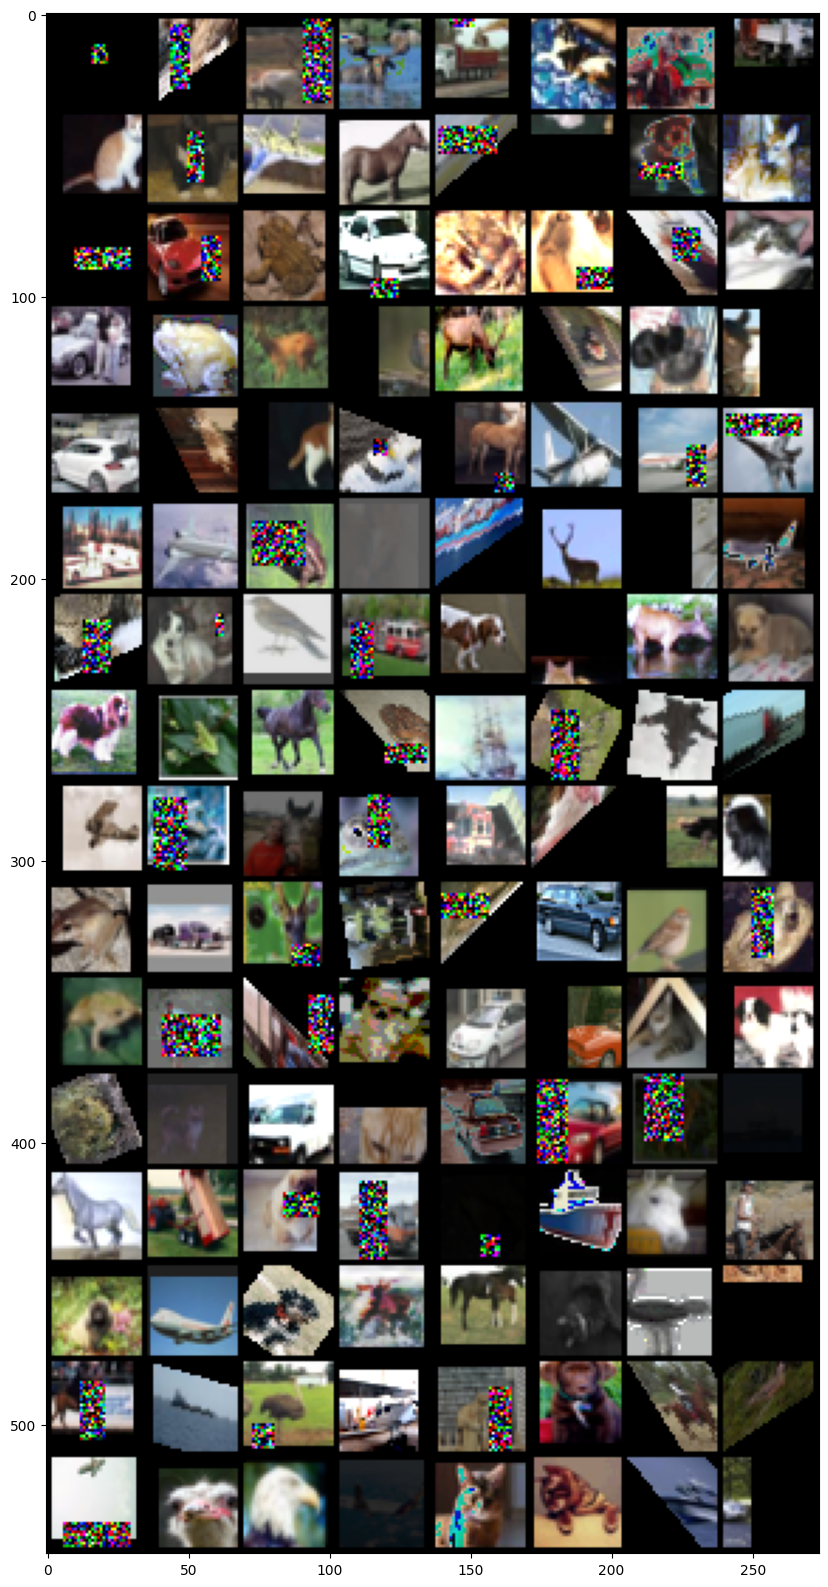

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(25, 20))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
print(f'Dataset type "{DATASET_TYPE}" displaying...\n')

if DATASET_TYPE=='custom':
    dataiter = iter(custom_trainloader)
    images, labels, confidences = next(dataiter)
    # print labels 
    if isinstance(confidences, list):
        # in case we have confidence 
        confidences = confidences[1]
        
    print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}' for j in range(batch_size)))
elif DATASET_TYPE=='baseline':
#     if training baseline model
    dataiter = iter(baseline_trainloader)
    images, labels = next(dataiter)
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
else:
    raise ValueError(f'Dataset type {DATASET_TYPE} not supported')
    
# show images
imshow(torchvision.utils.make_grid(images))

## Define WideResNet 28_4

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=num_classes, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

## Model Training

In [9]:
# Initialize the model
net = WideResNet_28_4(num_classes=num_classes)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [10]:
def soft_loss(pred, label, confidence, reweight=False):
    log_prob = F.log_softmax(pred, dim=1)
    n_class = pred.size(1)

    # Make soft one-hot target
    label = label.unsqueeze(1)
    confidence = confidence.unsqueeze(1).float()
    # soft one_hot
    one_hot = torch.ones_like(pred) * (1 - confidence) / (n_class - 1)
    one_hot.scatter_(dim=1, index=label, src=confidence)
    
    # hard one_hot
#     one_hot = torch.zeros_like(pred)
#     one_hot.scatter_(dim=1, index=label, value=1.0)
    # Compute weighted KL loss
    kl = F.kl_div(input=log_prob, target=one_hot, reduction="none").sum(-1)
    kl = kl.unsqueeze(1)  # Unweighted
    if reweight:
        kl = confidence * kl  # Weighted
    return kl.mean()

In [11]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = EPOCHS
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# For plotting
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
    test_loss = 0.0
    confidences = None
    
    net.train()
    
    if DATASET_TYPE=='baseline':
        trainloader = baseline_trainloader
    elif DATASET_TYPE=='custom':
        trainloader = custom_trainloader
    else:
        raise ValueError('Dataset type is not Valid!')
    
    for i, data in enumerate(trainloader):
            
        if DATASET_TYPE=='baseline':
            inputs, labels = data
        elif DATASET_TYPE=='custom':
            inputs, labels, confidences = data
            # get the inputs
            """when the model returns [augmentation_magnitude, confidence_aa], which is the case
            only when TA with soft labels is applied."""
            if isinstance(confidences, list):
                confidences = confidences[1]
            confidences = confidences.to(device)
        else:
            raise ValueError('Dataset type is not Valid!')
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
        # labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
        outputs = outputs.to(device)
        
        if DATASET_TYPE=='custom':
            loss = soft_loss(pred=outputs, label=labels, confidence=confidences, reweight=REWEIGHT)
        else:
            loss = criterion(outputs, labels)
        
        # Check for correct training
        if np.isnan(loss.detach().cpu().numpy()):
            raise ValueError('Loss calculation not correct')
    
        loss.backward()
        optimizer.step()
        
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_train_loss = running_loss / len(custom_trainloader)
    train_losses.append(average_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
    average_test_loss = test_loss / len(custom_testloader)
    test_losses.append(average_test_loss)
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'\nEpoch {epoch + 1} - Train Loss: {average_train_loss:.3f} - Train Accuracy: {100 * train_accuracy: .2f} - Test Loss: {average_test_loss:.3f} - Test Accuracy: {100 * test_accuracy: .2f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = f'/kaggle/working/{DATASET_NAME}_net_ta_{DATASET_TYPE}_{epochs}.pth'
torch.save(net.state_dict(), PATH)


Start Training...



/usr/local/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: aten::kl_div: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeImplicitAutograd). If your operator is not differentiable, or to squash this warning and use the previous behavior, please register torch::CppFunction::makeFallthrough() to DispatchKey::Autograd. (Triggered internally at ../torch/csrc/autograd/autograd_not_implemented_fallback.cpp:63.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Epoch 1 - Train Loss: 1.911 - Train Accuracy:  26.03 - Test Loss: 1.889 - Test Accuracy:  39.03

Processing time:  85.570492 seconds.



Epoch 2 - Train Loss: 1.609 - Train Accuracy:  39.01 - Test Loss: 2.857 - Test Accuracy:  32.46

Processing time:  48.056140 seconds.



Epoch 3 - Train Loss: 1.396 - Train Accuracy:  47.80 - Test Loss: 1.343 - Test Accuracy:  57.00

Processing time:  35.488206 seconds.



Epoch 4 - Train Loss: 1.260 - Train Accuracy:  53.34 - Test Loss: 1.162 - Test Accuracy:  63.36

Processing time:  35.988400 seconds.



Epoch 5 - Train Loss: 1.170 - Train Accuracy:  56.85 - Test Loss: 1.287 - Test Accuracy:  62.16

Processing time:  35.230921 seconds.



Epoch 6 - Train Loss: 1.093 - Train Accuracy:  59.57 - Test Loss: 0.908 - Test Accuracy:  70.65

Processing time:  36.581969 seconds.



Epoch 7 - Train Loss: 1.029 - Train Accuracy:  61.92 - Test Loss: 0.875 - Test Accuracy:  71.98

Processing time:  35.956834 seconds.



Epoch 8 - Train Loss: 0.964 - Train Accuracy:  64.63 - Test Loss: 0.761 - Test Accuracy:  76.32

Processing time:  36.530133 seconds.



Epoch 9 - Train Loss: 0.919 - Train Accuracy:  66.10 - Test Loss: 0.944 - Test Accuracy:  72.31

Processing time:  35.150039 seconds.



Epoch 10 - Train Loss: 0.889 - Train Accuracy:  67.32 - Test Loss: 0.723 - Test Accuracy:  77.21

Processing time:  35.241492 seconds.



Epoch 11 - Train Loss: 0.854 - Train Accuracy:  68.50 - Test Loss: 0.691 - Test Accuracy:  78.92

Processing time:  35.146994 seconds.



Epoch 12 - Train Loss: 0.824 - Train Accuracy:  69.81 - Test Loss: 0.771 - Test Accuracy:  78.00

Processing time:  38.801499 seconds.



Epoch 13 - Train Loss: 0.805 - Train Accuracy:  70.43 - Test Loss: 0.588 - Test Accuracy:  81.10

Processing time:  37.276311 seconds.



Epoch 14 - Train Loss: 0.785 - Train Accuracy:  71.00 - Test Loss: 0.863 - Test Accuracy:  74.22

Processing time:  36.158099 seconds.



Epoch 15 - Train Loss: 0.768 - Train Accuracy:  71.88 - Test Loss: 0.563 - Test Accuracy:  82.94

Processing time:  39.300771 seconds.



Epoch 16 - Train Loss: 0.756 - Train Accuracy:  72.40 - Test Loss: 0.520 - Test Accuracy:  83.05

Processing time:  35.063100 seconds.



Epoch 17 - Train Loss: 0.729 - Train Accuracy:  73.40 - Test Loss: 0.737 - Test Accuracy:  79.85

Processing time:  35.067581 seconds.



Epoch 18 - Train Loss: 0.729 - Train Accuracy:  73.32 - Test Loss: 0.578 - Test Accuracy:  81.52

Processing time:  34.886234 seconds.



Epoch 19 - Train Loss: 0.715 - Train Accuracy:  73.63 - Test Loss: 0.425 - Test Accuracy:  86.77

Processing time:  35.356011 seconds.



Epoch 20 - Train Loss: 0.704 - Train Accuracy:  74.13 - Test Loss: 0.413 - Test Accuracy:  86.49

Processing time:  35.308592 seconds.



Epoch 21 - Train Loss: 0.694 - Train Accuracy:  74.54 - Test Loss: 0.441 - Test Accuracy:  85.90

Processing time:  37.108426 seconds.



Epoch 22 - Train Loss: 0.682 - Train Accuracy:  74.99 - Test Loss: 0.540 - Test Accuracy:  83.21

Processing time:  36.409454 seconds.



Epoch 23 - Train Loss: 0.669 - Train Accuracy:  75.75 - Test Loss: 0.427 - Test Accuracy:  86.67

Processing time:  36.934331 seconds.



Epoch 24 - Train Loss: 0.667 - Train Accuracy:  75.81 - Test Loss: 0.359 - Test Accuracy:  88.35

Processing time:  35.135482 seconds.



Epoch 25 - Train Loss: 0.654 - Train Accuracy:  76.21 - Test Loss: 0.558 - Test Accuracy:  83.70

Processing time:  35.212449 seconds.



Epoch 26 - Train Loss: 0.651 - Train Accuracy:  76.22 - Test Loss: 0.457 - Test Accuracy:  86.20

Processing time:  35.382086 seconds.



Epoch 27 - Train Loss: 0.646 - Train Accuracy:  76.45 - Test Loss: 0.563 - Test Accuracy:  83.31

Processing time:  37.076058 seconds.



Epoch 28 - Train Loss: 0.639 - Train Accuracy:  76.51 - Test Loss: 0.556 - Test Accuracy:  83.63

Processing time:  35.401386 seconds.



Epoch 29 - Train Loss: 0.640 - Train Accuracy:  76.63 - Test Loss: 0.421 - Test Accuracy:  87.26

Processing time:  36.773357 seconds.



Epoch 30 - Train Loss: 0.628 - Train Accuracy:  77.27 - Test Loss: 0.410 - Test Accuracy:  87.16

Processing time:  37.118467 seconds.



Epoch 31 - Train Loss: 0.628 - Train Accuracy:  76.92 - Test Loss: 0.376 - Test Accuracy:  88.53

Processing time:  36.736988 seconds.



Epoch 32 - Train Loss: 0.623 - Train Accuracy:  77.23 - Test Loss: 0.397 - Test Accuracy:  87.77

Processing time:  37.288446 seconds.



Epoch 33 - Train Loss: 0.614 - Train Accuracy:  77.62 - Test Loss: 0.354 - Test Accuracy:  88.78

Processing time:  36.858812 seconds.



Epoch 34 - Train Loss: 0.613 - Train Accuracy:  77.46 - Test Loss: 0.388 - Test Accuracy:  88.01

Processing time:  36.082188 seconds.



Epoch 35 - Train Loss: 0.611 - Train Accuracy:  77.59 - Test Loss: 0.332 - Test Accuracy:  89.32

Processing time:  35.917117 seconds.



Epoch 36 - Train Loss: 0.594 - Train Accuracy:  78.29 - Test Loss: 0.329 - Test Accuracy:  89.05

Processing time:  36.398610 seconds.



Epoch 37 - Train Loss: 0.598 - Train Accuracy:  78.18 - Test Loss: 0.356 - Test Accuracy:  88.80

Processing time:  35.734991 seconds.



Epoch 38 - Train Loss: 0.589 - Train Accuracy:  78.46 - Test Loss: 0.362 - Test Accuracy:  88.46

Processing time:  35.908365 seconds.



Epoch 39 - Train Loss: 0.586 - Train Accuracy:  78.45 - Test Loss: 0.418 - Test Accuracy:  86.21

Processing time:  35.817619 seconds.



Epoch 40 - Train Loss: 0.592 - Train Accuracy:  78.42 - Test Loss: 0.346 - Test Accuracy:  88.84

Processing time:  37.442942 seconds.



Epoch 41 - Train Loss: 0.579 - Train Accuracy:  79.00 - Test Loss: 0.355 - Test Accuracy:  89.45

Processing time:  36.125368 seconds.



Epoch 42 - Train Loss: 0.582 - Train Accuracy:  78.76 - Test Loss: 0.377 - Test Accuracy:  88.25

Processing time:  36.235860 seconds.



Epoch 43 - Train Loss: 0.568 - Train Accuracy:  79.19 - Test Loss: 0.366 - Test Accuracy:  88.63

Processing time:  36.033202 seconds.



Epoch 44 - Train Loss: 0.570 - Train Accuracy:  79.28 - Test Loss: 0.444 - Test Accuracy:  85.54

Processing time:  36.107630 seconds.



Epoch 45 - Train Loss: 0.574 - Train Accuracy:  78.93 - Test Loss: 0.315 - Test Accuracy:  89.77

Processing time:  35.727998 seconds.



Epoch 46 - Train Loss: 0.560 - Train Accuracy:  79.51 - Test Loss: 0.308 - Test Accuracy:  90.62

Processing time:  35.928496 seconds.



Epoch 47 - Train Loss: 0.560 - Train Accuracy:  79.56 - Test Loss: 0.337 - Test Accuracy:  89.35

Processing time:  35.896366 seconds.



Epoch 48 - Train Loss: 0.554 - Train Accuracy:  79.95 - Test Loss: 0.320 - Test Accuracy:  90.02

Processing time:  39.294436 seconds.



Epoch 49 - Train Loss: 0.559 - Train Accuracy:  79.58 - Test Loss: 0.330 - Test Accuracy:  89.63

Processing time:  36.106188 seconds.



Epoch 50 - Train Loss: 0.548 - Train Accuracy:  80.01 - Test Loss: 0.368 - Test Accuracy:  88.01

Processing time:  36.351785 seconds.



Epoch 51 - Train Loss: 0.554 - Train Accuracy:  79.74 - Test Loss: 0.371 - Test Accuracy:  88.47

Processing time:  36.534979 seconds.



Epoch 52 - Train Loss: 0.546 - Train Accuracy:  80.05 - Test Loss: 0.326 - Test Accuracy:  89.87

Processing time:  35.879705 seconds.



Epoch 53 - Train Loss: 0.549 - Train Accuracy:  79.92 - Test Loss: 0.318 - Test Accuracy:  90.54

Processing time:  36.201271 seconds.



Epoch 54 - Train Loss: 0.544 - Train Accuracy:  79.96 - Test Loss: 0.550 - Test Accuracy:  83.95

Processing time:  36.877897 seconds.



Epoch 55 - Train Loss: 0.541 - Train Accuracy:  80.25 - Test Loss: 0.361 - Test Accuracy:  88.83

Processing time:  36.758568 seconds.



Epoch 56 - Train Loss: 0.537 - Train Accuracy:  80.29 - Test Loss: 0.301 - Test Accuracy:  90.59

Processing time:  36.193456 seconds.



Epoch 57 - Train Loss: 0.531 - Train Accuracy:  80.59 - Test Loss: 0.390 - Test Accuracy:  88.39

Processing time:  36.057107 seconds.



Epoch 58 - Train Loss: 0.531 - Train Accuracy:  80.54 - Test Loss: 0.311 - Test Accuracy:  89.89

Processing time:  36.379420 seconds.



Epoch 59 - Train Loss: 0.524 - Train Accuracy:  80.90 - Test Loss: 0.353 - Test Accuracy:  89.32

Processing time:  37.402468 seconds.



Epoch 60 - Train Loss: 0.524 - Train Accuracy:  80.76 - Test Loss: 0.317 - Test Accuracy:  90.12

Processing time:  35.751072 seconds.



Epoch 61 - Train Loss: 0.524 - Train Accuracy:  80.79 - Test Loss: 0.304 - Test Accuracy:  90.52

Processing time:  36.217433 seconds.



Epoch 62 - Train Loss: 0.512 - Train Accuracy:  81.29 - Test Loss: 0.319 - Test Accuracy:  90.59

Processing time:  35.931581 seconds.



Epoch 63 - Train Loss: 0.517 - Train Accuracy:  80.96 - Test Loss: 0.308 - Test Accuracy:  90.06

Processing time:  35.672752 seconds.



Epoch 64 - Train Loss: 0.518 - Train Accuracy:  81.04 - Test Loss: 0.359 - Test Accuracy:  88.74

Processing time:  36.618222 seconds.



Epoch 65 - Train Loss: 0.509 - Train Accuracy:  81.51 - Test Loss: 0.258 - Test Accuracy:  92.07

Processing time:  35.840640 seconds.



Epoch 66 - Train Loss: 0.507 - Train Accuracy:  81.53 - Test Loss: 0.254 - Test Accuracy:  92.08

Processing time:  36.264145 seconds.



Epoch 67 - Train Loss: 0.505 - Train Accuracy:  81.66 - Test Loss: 0.341 - Test Accuracy:  89.00

Processing time:  36.363322 seconds.



Epoch 68 - Train Loss: 0.507 - Train Accuracy:  81.35 - Test Loss: 0.265 - Test Accuracy:  91.77

Processing time:  35.950410 seconds.



Epoch 69 - Train Loss: 0.500 - Train Accuracy:  81.73 - Test Loss: 0.292 - Test Accuracy:  90.82

Processing time:  36.041569 seconds.



Epoch 70 - Train Loss: 0.500 - Train Accuracy:  81.63 - Test Loss: 0.356 - Test Accuracy:  88.80

Processing time:  35.795919 seconds.



Epoch 71 - Train Loss: 0.499 - Train Accuracy:  81.67 - Test Loss: 0.261 - Test Accuracy:  91.41

Processing time:  35.666807 seconds.



Epoch 72 - Train Loss: 0.493 - Train Accuracy:  82.12 - Test Loss: 0.280 - Test Accuracy:  91.02

Processing time:  35.470835 seconds.



Epoch 73 - Train Loss: 0.493 - Train Accuracy:  82.00 - Test Loss: 0.311 - Test Accuracy:  90.06

Processing time:  36.400017 seconds.



Epoch 74 - Train Loss: 0.490 - Train Accuracy:  81.95 - Test Loss: 0.257 - Test Accuracy:  92.12

Processing time:  36.233803 seconds.



Epoch 75 - Train Loss: 0.487 - Train Accuracy:  82.40 - Test Loss: 0.325 - Test Accuracy:  90.09

Processing time:  36.899436 seconds.



Epoch 76 - Train Loss: 0.488 - Train Accuracy:  82.34 - Test Loss: 0.258 - Test Accuracy:  91.91

Processing time:  35.944242 seconds.



Epoch 77 - Train Loss: 0.487 - Train Accuracy:  82.24 - Test Loss: 0.320 - Test Accuracy:  90.51

Processing time:  36.295256 seconds.



Epoch 78 - Train Loss: 0.477 - Train Accuracy:  82.57 - Test Loss: 0.265 - Test Accuracy:  91.91

Processing time:  36.694868 seconds.



Epoch 79 - Train Loss: 0.482 - Train Accuracy:  82.32 - Test Loss: 0.289 - Test Accuracy:  91.23

Processing time:  36.027738 seconds.



Epoch 80 - Train Loss: 0.475 - Train Accuracy:  82.71 - Test Loss: 0.320 - Test Accuracy:  89.71

Processing time:  35.709314 seconds.



Epoch 81 - Train Loss: 0.473 - Train Accuracy:  82.67 - Test Loss: 0.453 - Test Accuracy:  87.01

Processing time:  35.788322 seconds.



Epoch 82 - Train Loss: 0.471 - Train Accuracy:  82.86 - Test Loss: 0.249 - Test Accuracy:  92.31

Processing time:  35.509140 seconds.



Epoch 83 - Train Loss: 0.473 - Train Accuracy:  82.78 - Test Loss: 0.291 - Test Accuracy:  90.63

Processing time:  35.151307 seconds.



Epoch 84 - Train Loss: 0.474 - Train Accuracy:  82.81 - Test Loss: 0.250 - Test Accuracy:  92.10

Processing time:  36.018824 seconds.



Epoch 85 - Train Loss: 0.460 - Train Accuracy:  83.21 - Test Loss: 0.271 - Test Accuracy:  91.49

Processing time:  35.333793 seconds.



Epoch 86 - Train Loss: 0.458 - Train Accuracy:  83.34 - Test Loss: 0.250 - Test Accuracy:  91.94

Processing time:  36.492062 seconds.



Epoch 87 - Train Loss: 0.463 - Train Accuracy:  83.10 - Test Loss: 0.256 - Test Accuracy:  92.26

Processing time:  35.928736 seconds.



Epoch 88 - Train Loss: 0.452 - Train Accuracy:  83.53 - Test Loss: 0.256 - Test Accuracy:  92.17

Processing time:  35.808776 seconds.



Epoch 89 - Train Loss: 0.457 - Train Accuracy:  83.44 - Test Loss: 0.255 - Test Accuracy:  92.12

Processing time:  36.096095 seconds.



Epoch 90 - Train Loss: 0.451 - Train Accuracy:  83.70 - Test Loss: 0.251 - Test Accuracy:  91.89

Processing time:  35.991452 seconds.



Epoch 91 - Train Loss: 0.449 - Train Accuracy:  83.57 - Test Loss: 0.256 - Test Accuracy:  92.41

Processing time:  36.637077 seconds.



Epoch 92 - Train Loss: 0.449 - Train Accuracy:  83.73 - Test Loss: 0.261 - Test Accuracy:  91.83

Processing time:  36.278386 seconds.



Epoch 93 - Train Loss: 0.449 - Train Accuracy:  83.56 - Test Loss: 0.244 - Test Accuracy:  92.34

Processing time:  38.877345 seconds.



Epoch 94 - Train Loss: 0.442 - Train Accuracy:  83.89 - Test Loss: 0.241 - Test Accuracy:  92.17

Processing time:  35.747427 seconds.



Epoch 95 - Train Loss: 0.445 - Train Accuracy:  83.74 - Test Loss: 0.214 - Test Accuracy:  93.20

Processing time:  35.880633 seconds.



Epoch 96 - Train Loss: 0.436 - Train Accuracy:  84.10 - Test Loss: 0.219 - Test Accuracy:  93.14

Processing time:  37.075119 seconds.



Epoch 97 - Train Loss: 0.442 - Train Accuracy:  83.94 - Test Loss: 0.283 - Test Accuracy:  91.31

Processing time:  36.504118 seconds.



Epoch 98 - Train Loss: 0.430 - Train Accuracy:  84.45 - Test Loss: 0.232 - Test Accuracy:  93.07

Processing time:  36.764283 seconds.



Epoch 99 - Train Loss: 0.429 - Train Accuracy:  84.30 - Test Loss: 0.227 - Test Accuracy:  93.19

Processing time:  36.250121 seconds.



Epoch 100 - Train Loss: 0.437 - Train Accuracy:  84.06 - Test Loss: 0.253 - Test Accuracy:  92.45

Processing time:  35.599218 seconds.



Epoch 101 - Train Loss: 0.422 - Train Accuracy:  84.72 - Test Loss: 0.267 - Test Accuracy:  92.06

Processing time:  36.067921 seconds.



Epoch 102 - Train Loss: 0.425 - Train Accuracy:  84.44 - Test Loss: 0.231 - Test Accuracy:  93.04

Processing time:  36.379018 seconds.



Epoch 103 - Train Loss: 0.426 - Train Accuracy:  84.39 - Test Loss: 0.222 - Test Accuracy:  92.91

Processing time:  36.068496 seconds.



Epoch 104 - Train Loss: 0.419 - Train Accuracy:  84.84 - Test Loss: 0.212 - Test Accuracy:  93.52

Processing time:  35.936818 seconds.



Epoch 105 - Train Loss: 0.417 - Train Accuracy:  84.75 - Test Loss: 0.230 - Test Accuracy:  93.02

Processing time:  36.735071 seconds.



Epoch 106 - Train Loss: 0.416 - Train Accuracy:  84.74 - Test Loss: 0.246 - Test Accuracy:  92.69

Processing time:  36.474271 seconds.



Epoch 107 - Train Loss: 0.410 - Train Accuracy:  85.03 - Test Loss: 0.185 - Test Accuracy:  93.99

Processing time:  36.387573 seconds.



Epoch 108 - Train Loss: 0.408 - Train Accuracy:  85.17 - Test Loss: 0.228 - Test Accuracy:  93.40

Processing time:  36.605263 seconds.



Epoch 109 - Train Loss: 0.403 - Train Accuracy:  85.33 - Test Loss: 0.228 - Test Accuracy:  93.03

Processing time:  35.863461 seconds.



Epoch 110 - Train Loss: 0.404 - Train Accuracy:  85.35 - Test Loss: 0.202 - Test Accuracy:  93.77

Processing time:  36.261901 seconds.



Epoch 111 - Train Loss: 0.403 - Train Accuracy:  85.39 - Test Loss: 0.195 - Test Accuracy:  93.64

Processing time:  35.503093 seconds.



Epoch 112 - Train Loss: 0.399 - Train Accuracy:  85.52 - Test Loss: 0.208 - Test Accuracy:  93.40

Processing time:  36.234177 seconds.



Epoch 113 - Train Loss: 0.389 - Train Accuracy:  85.89 - Test Loss: 0.242 - Test Accuracy:  92.58

Processing time:  36.471700 seconds.



Epoch 114 - Train Loss: 0.394 - Train Accuracy:  85.68 - Test Loss: 0.204 - Test Accuracy:  93.79

Processing time:  37.897747 seconds.



Epoch 115 - Train Loss: 0.393 - Train Accuracy:  85.70 - Test Loss: 0.187 - Test Accuracy:  94.16

Processing time:  36.152859 seconds.



Epoch 116 - Train Loss: 0.389 - Train Accuracy:  85.84 - Test Loss: 0.205 - Test Accuracy:  93.59

Processing time:  36.293511 seconds.



Epoch 117 - Train Loss: 0.386 - Train Accuracy:  85.82 - Test Loss: 0.218 - Test Accuracy:  93.47

Processing time:  36.343786 seconds.



Epoch 118 - Train Loss: 0.389 - Train Accuracy:  85.80 - Test Loss: 0.212 - Test Accuracy:  93.47

Processing time:  36.359975 seconds.



Epoch 119 - Train Loss: 0.384 - Train Accuracy:  85.97 - Test Loss: 0.183 - Test Accuracy:  94.31

Processing time:  35.487941 seconds.



Epoch 120 - Train Loss: 0.377 - Train Accuracy:  86.23 - Test Loss: 0.189 - Test Accuracy:  94.06

Processing time:  36.476216 seconds.



Epoch 121 - Train Loss: 0.378 - Train Accuracy:  86.21 - Test Loss: 0.185 - Test Accuracy:  94.30

Processing time:  36.314342 seconds.



Epoch 122 - Train Loss: 0.373 - Train Accuracy:  86.50 - Test Loss: 0.204 - Test Accuracy:  94.08

Processing time:  36.447438 seconds.



Epoch 123 - Train Loss: 0.374 - Train Accuracy:  86.42 - Test Loss: 0.173 - Test Accuracy:  94.78

Processing time:  35.817747 seconds.



Epoch 124 - Train Loss: 0.376 - Train Accuracy:  86.47 - Test Loss: 0.191 - Test Accuracy:  94.19

Processing time:  35.938884 seconds.



Epoch 125 - Train Loss: 0.363 - Train Accuracy:  86.78 - Test Loss: 0.182 - Test Accuracy:  94.45

Processing time:  36.524790 seconds.



Epoch 126 - Train Loss: 0.354 - Train Accuracy:  87.16 - Test Loss: 0.182 - Test Accuracy:  94.45

Processing time:  36.414412 seconds.



Epoch 127 - Train Loss: 0.361 - Train Accuracy:  86.81 - Test Loss: 0.189 - Test Accuracy:  94.25

Processing time:  36.059884 seconds.



Epoch 128 - Train Loss: 0.362 - Train Accuracy:  86.70 - Test Loss: 0.192 - Test Accuracy:  94.17

Processing time:  36.223574 seconds.



Epoch 129 - Train Loss: 0.357 - Train Accuracy:  87.00 - Test Loss: 0.170 - Test Accuracy:  94.83

Processing time:  35.361165 seconds.



Epoch 130 - Train Loss: 0.348 - Train Accuracy:  87.53 - Test Loss: 0.202 - Test Accuracy:  94.03

Processing time:  35.081934 seconds.



Epoch 131 - Train Loss: 0.346 - Train Accuracy:  87.50 - Test Loss: 0.187 - Test Accuracy:  94.40

Processing time:  35.088150 seconds.



Epoch 132 - Train Loss: 0.344 - Train Accuracy:  87.45 - Test Loss: 0.168 - Test Accuracy:  95.00

Processing time:  34.888496 seconds.



Epoch 133 - Train Loss: 0.345 - Train Accuracy:  87.41 - Test Loss: 0.174 - Test Accuracy:  94.64

Processing time:  36.268375 seconds.



Epoch 134 - Train Loss: 0.342 - Train Accuracy:  87.61 - Test Loss: 0.173 - Test Accuracy:  94.73

Processing time:  34.806932 seconds.



Epoch 135 - Train Loss: 0.337 - Train Accuracy:  87.70 - Test Loss: 0.198 - Test Accuracy:  94.45

Processing time:  35.783225 seconds.



Epoch 136 - Train Loss: 0.332 - Train Accuracy:  87.94 - Test Loss: 0.196 - Test Accuracy:  94.37

Processing time:  34.961962 seconds.



Epoch 137 - Train Loss: 0.326 - Train Accuracy:  88.15 - Test Loss: 0.182 - Test Accuracy:  94.72

Processing time:  35.039251 seconds.



Epoch 138 - Train Loss: 0.335 - Train Accuracy:  87.80 - Test Loss: 0.186 - Test Accuracy:  94.59

Processing time:  36.117554 seconds.



Epoch 139 - Train Loss: 0.329 - Train Accuracy:  88.15 - Test Loss: 0.192 - Test Accuracy:  94.36

Processing time:  34.834144 seconds.



Epoch 140 - Train Loss: 0.326 - Train Accuracy:  88.23 - Test Loss: 0.174 - Test Accuracy:  94.92

Processing time:  36.005407 seconds.



Epoch 141 - Train Loss: 0.318 - Train Accuracy:  88.49 - Test Loss: 0.170 - Test Accuracy:  94.89

Processing time:  36.657581 seconds.



Epoch 142 - Train Loss: 0.319 - Train Accuracy:  88.48 - Test Loss: 0.205 - Test Accuracy:  93.99

Processing time:  36.179745 seconds.



Epoch 143 - Train Loss: 0.320 - Train Accuracy:  88.37 - Test Loss: 0.177 - Test Accuracy:  94.75

Processing time:  36.443731 seconds.



Epoch 144 - Train Loss: 0.320 - Train Accuracy:  88.44 - Test Loss: 0.163 - Test Accuracy:  95.09

Processing time:  35.620662 seconds.



Epoch 145 - Train Loss: 0.306 - Train Accuracy:  88.92 - Test Loss: 0.163 - Test Accuracy:  95.08

Processing time:  35.060696 seconds.



Epoch 146 - Train Loss: 0.306 - Train Accuracy:  88.87 - Test Loss: 0.160 - Test Accuracy:  95.32

Processing time:  35.124930 seconds.



Epoch 147 - Train Loss: 0.309 - Train Accuracy:  88.75 - Test Loss: 0.170 - Test Accuracy:  95.21

Processing time:  35.136302 seconds.



Epoch 148 - Train Loss: 0.299 - Train Accuracy:  89.20 - Test Loss: 0.167 - Test Accuracy:  95.16

Processing time:  36.262009 seconds.



Epoch 149 - Train Loss: 0.303 - Train Accuracy:  89.09 - Test Loss: 0.160 - Test Accuracy:  95.21

Processing time:  36.171193 seconds.



Epoch 150 - Train Loss: 0.298 - Train Accuracy:  89.24 - Test Loss: 0.158 - Test Accuracy:  95.47

Processing time:  36.107785 seconds.



Epoch 151 - Train Loss: 0.292 - Train Accuracy:  89.43 - Test Loss: 0.161 - Test Accuracy:  95.23

Processing time:  34.925418 seconds.



Epoch 152 - Train Loss: 0.295 - Train Accuracy:  89.23 - Test Loss: 0.163 - Test Accuracy:  95.59

Processing time:  34.837471 seconds.



Epoch 153 - Train Loss: 0.296 - Train Accuracy:  89.44 - Test Loss: 0.155 - Test Accuracy:  95.75

Processing time:  35.585129 seconds.



Epoch 154 - Train Loss: 0.289 - Train Accuracy:  89.43 - Test Loss: 0.159 - Test Accuracy:  95.59

Processing time:  35.029432 seconds.



Epoch 155 - Train Loss: 0.283 - Train Accuracy:  89.76 - Test Loss: 0.155 - Test Accuracy:  95.63

Processing time:  36.956604 seconds.



Epoch 156 - Train Loss: 0.280 - Train Accuracy:  89.92 - Test Loss: 0.150 - Test Accuracy:  95.50

Processing time:  36.377532 seconds.



Epoch 157 - Train Loss: 0.283 - Train Accuracy:  89.74 - Test Loss: 0.153 - Test Accuracy:  95.64

Processing time:  37.657904 seconds.



Epoch 158 - Train Loss: 0.282 - Train Accuracy:  89.77 - Test Loss: 0.156 - Test Accuracy:  95.61

Processing time:  36.351068 seconds.



Epoch 159 - Train Loss: 0.275 - Train Accuracy:  90.12 - Test Loss: 0.146 - Test Accuracy:  95.82

Processing time:  36.565924 seconds.



Epoch 160 - Train Loss: 0.273 - Train Accuracy:  90.24 - Test Loss: 0.143 - Test Accuracy:  96.04

Processing time:  36.359573 seconds.



Epoch 161 - Train Loss: 0.267 - Train Accuracy:  90.39 - Test Loss: 0.144 - Test Accuracy:  95.84

Processing time:  36.630299 seconds.



Epoch 162 - Train Loss: 0.267 - Train Accuracy:  90.26 - Test Loss: 0.141 - Test Accuracy:  95.79

Processing time:  36.556877 seconds.



Epoch 163 - Train Loss: 0.264 - Train Accuracy:  90.32 - Test Loss: 0.153 - Test Accuracy:  95.78

Processing time:  35.897481 seconds.



Epoch 164 - Train Loss: 0.261 - Train Accuracy:  90.56 - Test Loss: 0.148 - Test Accuracy:  95.93

Processing time:  36.438746 seconds.



Epoch 165 - Train Loss: 0.260 - Train Accuracy:  90.73 - Test Loss: 0.150 - Test Accuracy:  95.96

Processing time:  35.952503 seconds.



Epoch 166 - Train Loss: 0.253 - Train Accuracy:  90.89 - Test Loss: 0.146 - Test Accuracy:  95.97

Processing time:  36.052590 seconds.



Epoch 167 - Train Loss: 0.256 - Train Accuracy:  90.71 - Test Loss: 0.136 - Test Accuracy:  95.97

Processing time:  35.862673 seconds.



Epoch 168 - Train Loss: 0.251 - Train Accuracy:  90.98 - Test Loss: 0.136 - Test Accuracy:  96.05

Processing time:  36.734385 seconds.



Epoch 169 - Train Loss: 0.252 - Train Accuracy:  90.90 - Test Loss: 0.141 - Test Accuracy:  96.02

Processing time:  35.811014 seconds.



Epoch 170 - Train Loss: 0.248 - Train Accuracy:  91.04 - Test Loss: 0.140 - Test Accuracy:  96.05

Processing time:  35.731974 seconds.



Epoch 171 - Train Loss: 0.239 - Train Accuracy:  91.43 - Test Loss: 0.135 - Test Accuracy:  96.15

Processing time:  35.665198 seconds.



Epoch 172 - Train Loss: 0.244 - Train Accuracy:  91.20 - Test Loss: 0.140 - Test Accuracy:  96.20

Processing time:  36.241842 seconds.



Epoch 173 - Train Loss: 0.242 - Train Accuracy:  91.20 - Test Loss: 0.139 - Test Accuracy:  96.13

Processing time:  35.910925 seconds.



Epoch 174 - Train Loss: 0.239 - Train Accuracy:  91.37 - Test Loss: 0.134 - Test Accuracy:  96.29

Processing time:  36.108013 seconds.



Epoch 175 - Train Loss: 0.242 - Train Accuracy:  91.24 - Test Loss: 0.133 - Test Accuracy:  96.37

Processing time:  35.894470 seconds.



Epoch 176 - Train Loss: 0.240 - Train Accuracy:  91.45 - Test Loss: 0.132 - Test Accuracy:  96.34

Processing time:  35.863921 seconds.



Epoch 177 - Train Loss: 0.238 - Train Accuracy:  91.52 - Test Loss: 0.135 - Test Accuracy:  96.39

Processing time:  35.299850 seconds.



Epoch 178 - Train Loss: 0.237 - Train Accuracy:  91.42 - Test Loss: 0.130 - Test Accuracy:  96.43

Processing time:  35.005572 seconds.



Epoch 179 - Train Loss: 0.232 - Train Accuracy:  91.60 - Test Loss: 0.131 - Test Accuracy:  96.43

Processing time:  35.604778 seconds.



Epoch 180 - Train Loss: 0.228 - Train Accuracy:  91.80 - Test Loss: 0.132 - Test Accuracy:  96.38

Processing time:  35.728442 seconds.



Epoch 181 - Train Loss: 0.229 - Train Accuracy:  91.74 - Test Loss: 0.135 - Test Accuracy:  96.36

Processing time:  34.978020 seconds.



Epoch 182 - Train Loss: 0.225 - Train Accuracy:  91.83 - Test Loss: 0.136 - Test Accuracy:  96.36

Processing time:  35.997066 seconds.



Epoch 183 - Train Loss: 0.225 - Train Accuracy:  91.98 - Test Loss: 0.128 - Test Accuracy:  96.61

Processing time:  35.243884 seconds.



Epoch 184 - Train Loss: 0.228 - Train Accuracy:  91.77 - Test Loss: 0.136 - Test Accuracy:  96.29

Processing time:  36.221570 seconds.



Epoch 185 - Train Loss: 0.227 - Train Accuracy:  91.89 - Test Loss: 0.127 - Test Accuracy:  96.61

Processing time:  37.038438 seconds.



Epoch 186 - Train Loss: 0.227 - Train Accuracy:  91.87 - Test Loss: 0.126 - Test Accuracy:  96.53

Processing time:  36.219939 seconds.



Epoch 187 - Train Loss: 0.219 - Train Accuracy:  92.11 - Test Loss: 0.128 - Test Accuracy:  96.58

Processing time:  35.739188 seconds.



Epoch 188 - Train Loss: 0.221 - Train Accuracy:  92.06 - Test Loss: 0.126 - Test Accuracy:  96.51

Processing time:  35.401848 seconds.



Epoch 189 - Train Loss: 0.224 - Train Accuracy:  91.89 - Test Loss: 0.125 - Test Accuracy:  96.56

Processing time:  35.263364 seconds.



Epoch 190 - Train Loss: 0.217 - Train Accuracy:  92.28 - Test Loss: 0.128 - Test Accuracy:  96.56

Processing time:  36.442869 seconds.



Epoch 191 - Train Loss: 0.223 - Train Accuracy:  91.93 - Test Loss: 0.128 - Test Accuracy:  96.58

Processing time:  36.430584 seconds.



Epoch 192 - Train Loss: 0.219 - Train Accuracy:  92.14 - Test Loss: 0.124 - Test Accuracy:  96.53

Processing time:  36.230172 seconds.



Epoch 193 - Train Loss: 0.217 - Train Accuracy:  92.12 - Test Loss: 0.122 - Test Accuracy:  96.73

Processing time:  36.354083 seconds.



Epoch 194 - Train Loss: 0.219 - Train Accuracy:  92.11 - Test Loss: 0.123 - Test Accuracy:  96.63

Processing time:  36.521124 seconds.



Epoch 195 - Train Loss: 0.216 - Train Accuracy:  92.17 - Test Loss: 0.124 - Test Accuracy:  96.58

Processing time:  36.323258 seconds.



Epoch 196 - Train Loss: 0.218 - Train Accuracy:  92.19 - Test Loss: 0.123 - Test Accuracy:  96.53

Processing time:  36.382320 seconds.



Epoch 197 - Train Loss: 0.220 - Train Accuracy:  92.11 - Test Loss: 0.126 - Test Accuracy:  96.61

Processing time:  36.417237 seconds.



Epoch 198 - Train Loss: 0.218 - Train Accuracy:  92.17 - Test Loss: 0.121 - Test Accuracy:  96.61

Processing time:  36.360984 seconds.



Epoch 199 - Train Loss: 0.216 - Train Accuracy:  92.18 - Test Loss: 0.127 - Test Accuracy:  96.52

Processing time:  37.437083 seconds.



Epoch 200 - Train Loss: 0.214 - Train Accuracy:  92.27 - Test Loss: 0.122 - Test Accuracy:  96.58

Processing time:  35.885848 seconds.
Finished Training


In [12]:
import csv

csv_path = f'/kaggle/working/{DATASET_NAME}_training_metrics.csv'
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Test Loss', 'Test Accuracy'])
    for epoch in range(epochs):
        writer.writerow([epoch + 1, train_losses[epoch], train_accuracies[epoch], test_losses[epoch], test_accuracies[epoch]])

print(f'\nMetrics saved to {csv_path}')


Metrics saved to /kaggle/working/CIFAR10_training_metrics.csv


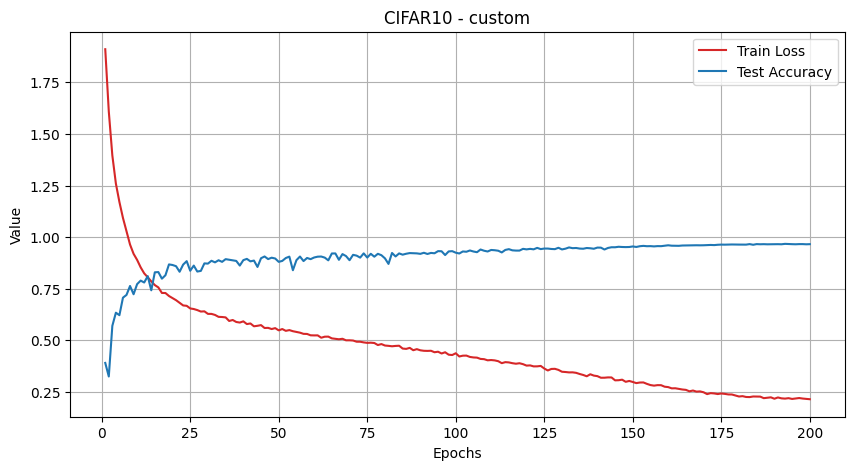

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='tab:red')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title(f'{DATASET_NAME} - {DATASET_TYPE}')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate the model on Testset

In [14]:
import torch
import numpy as np

# Evaluate the CIFAR-10 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-10 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

if not tpu:
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Clear CPU memory
    torch.cuda.ipc_collect()

# Define the list of corruptions
corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
               'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
               'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
               'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# Define the batch size
batch_size = 256 

# Create an empty dictionary to store corrupted datasets
corrupted_datasets = {}

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# List to store average accuracies for each corruption dataset
average_accuracies = []

# Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
for corruption in corruptions:
    print(f"Testing on corruption: {corruption}")

    # Load and test datasets for all 5 severity levels of the current corruption
    try:
        if DATASET_NAME=='CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
        elif DATASET_NAME=='CIFAR100':
            np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
        else:
            raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
            
        np_data_c_splits = np.array_split(np_data_c, 5)
        
        # List to store accuracies of all severity levels for averaging
        accuracies = []

        for i, np_data_c_split in enumerate(np_data_c_splits):
            custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

            # Testing loop for the current corruption dataset split
            correct = 0
            total = 0

            with torch.no_grad():
                images_loaded = 0  # Counter for images loaded for the current corruption
                for images, labels in custom_dataloader:
                    images_loaded += len(images)  # Increment the counter by the number of images loaded
                    images, labels = images.to(device), labels.to(device)
                    # Calculate outputs by running images through the network
                    outputs = net(images)
                    # The class with the highest energy is chosen as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                if total == 0:
                    print(f'No images found for {corruption} dataset split {i+1}.')
                else:
                    accuracy = 100 * correct / total
                    print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
                    accuracies.append(accuracy)

                # Print the number of images loaded for the current corruption dataset split
                #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
                if not tpu:
                    # Clear GPU memory
                    torch.cuda.empty_cache()
                    # Clear CPU memory
                    torch.cuda.ipc_collect()

                # Delete variables to free up memory
                del custom_dataset
                del custom_dataloader

        # Calculate and print the average accuracy for the corruption dataset
        if accuracies:
            average_accuracy = sum(accuracies) / len(accuracies)
            average_accuracies.append(average_accuracy)
            print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

    except FileNotFoundError:
        print(f'Corruption {corruption} dataset not found.')
        continue

# Calculate and print the average robust accuracy
if average_accuracies:
    average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
    print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
else:
    print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-10 test dataset: 96.58 %
Testing on corruption: gaussian_noise


Accuracy of the network on gaussian_noise dataset split 1: 87.76 %


Accuracy of the network on gaussian_noise dataset split 2: 76.72 %


Accuracy of the network on gaussian_noise dataset split 3: 63.47 %


Accuracy of the network on gaussian_noise dataset split 4: 56.63 %


Accuracy of the network on gaussian_noise dataset split 5: 50.77 %
Average accuracy for gaussian_noise dataset: 67.07 %
Testing on corruption: shot_noise


Accuracy of the network on shot_noise dataset split 1: 91.28 %


Accuracy of the network on shot_noise dataset split 2: 86.34 %


Accuracy of the network on shot_noise dataset split 3: 72.39 %


Accuracy of the network on shot_noise dataset split 4: 66.20 %


Accuracy of the network on shot_noise dataset split 5: 56.18 %
Average accuracy for shot_noise dataset: 74.48 %
Testing on corruption: impulse_noise


Accuracy of the network on impulse_noise dataset split 1: 95.39 %


Accuracy of the network on impulse_noise dataset split 2: 93.33 %


Accuracy of the network on impulse_noise dataset split 3: 90.83 %


Accuracy of the network on impulse_noise dataset split 4: 80.76 %


Accuracy of the network on impulse_noise dataset split 5: 68.03 %
Average accuracy for impulse_noise dataset: 85.67 %
Testing on corruption: defocus_blur


Accuracy of the network on defocus_blur dataset split 1: 96.65 %


Accuracy of the network on defocus_blur dataset split 2: 96.20 %


Accuracy of the network on defocus_blur dataset split 3: 95.54 %


Accuracy of the network on defocus_blur dataset split 4: 93.86 %


Accuracy of the network on defocus_blur dataset split 5: 89.63 %
Average accuracy for defocus_blur dataset: 94.38 %
Testing on corruption: glass_blur


Accuracy of the network on glass_blur dataset split 1: 82.86 %


Accuracy of the network on glass_blur dataset split 2: 83.99 %


Accuracy of the network on glass_blur dataset split 3: 85.13 %


Accuracy of the network on glass_blur dataset split 4: 71.33 %


Accuracy of the network on glass_blur dataset split 5: 73.34 %
Average accuracy for glass_blur dataset: 79.33 %
Testing on corruption: motion_blur


Accuracy of the network on motion_blur dataset split 1: 95.17 %


Accuracy of the network on motion_blur dataset split 2: 91.81 %


Accuracy of the network on motion_blur dataset split 3: 87.07 %


Accuracy of the network on motion_blur dataset split 4: 86.92 %


Accuracy of the network on motion_blur dataset split 5: 81.77 %
Average accuracy for motion_blur dataset: 88.55 %
Testing on corruption: zoom_blur


Accuracy of the network on zoom_blur dataset split 1: 95.05 %


Accuracy of the network on zoom_blur dataset split 2: 94.71 %


Accuracy of the network on zoom_blur dataset split 3: 93.84 %


Accuracy of the network on zoom_blur dataset split 4: 92.98 %


Accuracy of the network on zoom_blur dataset split 5: 90.77 %
Average accuracy for zoom_blur dataset: 93.47 %
Testing on corruption: snow


Accuracy of the network on snow dataset split 1: 94.84 %


Accuracy of the network on snow dataset split 2: 90.63 %


Accuracy of the network on snow dataset split 3: 91.13 %


Accuracy of the network on snow dataset split 4: 89.15 %


Accuracy of the network on snow dataset split 5: 86.29 %
Average accuracy for snow dataset: 90.41 %
Testing on corruption: frost


Accuracy of the network on frost dataset split 1: 94.29 %


Accuracy of the network on frost dataset split 2: 91.55 %


Accuracy of the network on frost dataset split 3: 86.02 %


Accuracy of the network on frost dataset split 4: 84.89 %


Accuracy of the network on frost dataset split 5: 77.97 %
Average accuracy for frost dataset: 86.94 %
Testing on corruption: fog


Accuracy of the network on fog dataset split 1: 96.59 %


Accuracy of the network on fog dataset split 2: 96.19 %


Accuracy of the network on fog dataset split 3: 95.45 %


Accuracy of the network on fog dataset split 4: 93.92 %


Accuracy of the network on fog dataset split 5: 84.18 %
Average accuracy for fog dataset: 93.27 %
Testing on corruption: brightness


Accuracy of the network on brightness dataset split 1: 96.60 %


Accuracy of the network on brightness dataset split 2: 96.50 %


Accuracy of the network on brightness dataset split 3: 96.22 %


Accuracy of the network on brightness dataset split 4: 96.00 %


Accuracy of the network on brightness dataset split 5: 95.19 %
Average accuracy for brightness dataset: 96.10 %
Testing on corruption: contrast


Accuracy of the network on contrast dataset split 1: 96.38 %


Accuracy of the network on contrast dataset split 2: 95.53 %


Accuracy of the network on contrast dataset split 3: 94.84 %


Accuracy of the network on contrast dataset split 4: 93.67 %


Accuracy of the network on contrast dataset split 5: 87.76 %
Average accuracy for contrast dataset: 93.64 %
Testing on corruption: elastic_transform


Accuracy of the network on elastic_transform dataset split 1: 94.57 %


Accuracy of the network on elastic_transform dataset split 2: 94.33 %


Accuracy of the network on elastic_transform dataset split 3: 93.93 %


Accuracy of the network on elastic_transform dataset split 4: 89.48 %


Accuracy of the network on elastic_transform dataset split 5: 83.31 %
Average accuracy for elastic_transform dataset: 91.12 %
Testing on corruption: pixelate


Accuracy of the network on pixelate dataset split 1: 95.59 %


Accuracy of the network on pixelate dataset split 2: 91.09 %


Accuracy of the network on pixelate dataset split 3: 86.06 %


Accuracy of the network on pixelate dataset split 4: 65.39 %


Accuracy of the network on pixelate dataset split 5: 43.12 %
Average accuracy for pixelate dataset: 76.25 %
Testing on corruption: jpeg_compression


Accuracy of the network on jpeg_compression dataset split 1: 90.38 %


Accuracy of the network on jpeg_compression dataset split 2: 86.25 %


Accuracy of the network on jpeg_compression dataset split 3: 84.50 %


Accuracy of the network on jpeg_compression dataset split 4: 81.68 %


Accuracy of the network on jpeg_compression dataset split 5: 78.10 %
Average accuracy for jpeg_compression dataset: 84.18 %
Testing on corruption: speckle_noise


Accuracy of the network on speckle_noise dataset split 1: 91.61 %


Accuracy of the network on speckle_noise dataset split 2: 83.70 %


Accuracy of the network on speckle_noise dataset split 3: 79.24 %


Accuracy of the network on speckle_noise dataset split 4: 69.08 %


Accuracy of the network on speckle_noise dataset split 5: 60.09 %
Average accuracy for speckle_noise dataset: 76.74 %
Testing on corruption: gaussian_blur


Accuracy of the network on gaussian_blur dataset split 1: 96.62 %


Accuracy of the network on gaussian_blur dataset split 2: 95.47 %


Accuracy of the network on gaussian_blur dataset split 3: 94.11 %


Accuracy of the network on gaussian_blur dataset split 4: 92.63 %


Accuracy of the network on gaussian_blur dataset split 5: 88.27 %
Average accuracy for gaussian_blur dataset: 93.42 %
Testing on corruption: spatter


Accuracy of the network on spatter dataset split 1: 95.73 %


Accuracy of the network on spatter dataset split 2: 93.95 %


Accuracy of the network on spatter dataset split 3: 91.19 %


Accuracy of the network on spatter dataset split 4: 94.75 %


Accuracy of the network on spatter dataset split 5: 91.87 %
Average accuracy for spatter dataset: 93.50 %
Testing on corruption: saturate


Accuracy of the network on saturate dataset split 1: 95.43 %


Accuracy of the network on saturate dataset split 2: 93.57 %


Accuracy of the network on saturate dataset split 3: 96.38 %


Accuracy of the network on saturate dataset split 4: 95.45 %


Accuracy of the network on saturate dataset split 5: 93.91 %
Average accuracy for saturate dataset: 94.95 %
Average Robust Accuracy: 87.02 %


In [15]:
# # Load the model checkpoint
# net = WideResNet_28_4(num_classes=num_classes)
# checkpoint_path = '/kaggle/working/MasterArbeit/models/CIFAR10_net_ta_custom_100.pth'
# checkpoint = torch.load(checkpoint_path)
# net.load_state_dict(checkpoint, strict=False)
# net.to(device)

# import torch
# import numpy as np


# # Evaluate the CIFAR-10 dataset
# correct = 0
# total = 0

# with torch.no_grad():
#     net.eval()
#     for images, labels in baseline_testloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     if total == 0:
#         print('No images found for CIFAR-10 dataset.')
#     else:
#         cifar10_accuracy = 100 * correct / total
#         print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')
        
# if not tpu:
#     # Clear GPU memory
#     torch.cuda.empty_cache()

#     # Clear CPU memory
#     torch.cuda.ipc_collect()

# # Define the list of corruptions
# corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
#                'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
#                'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
#                'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# # Define the batch size
# batch_size = 256 

# # Create an empty dictionary to store corrupted datasets
# corrupted_datasets = {}

# # Prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # List to store average accuracies for each corruption dataset
# average_accuracies = []

# # Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
# for corruption in corruptions:
#     print(f"Testing on corruption: {corruption}")

#     # Load and test datasets for all 5 severity levels of the current corruption
#     try:
#         if DATASET_NAME=='CIFAR10':
#             np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
#         elif DATASET_NAME=='CIFAR100':
#             np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
#         else:
#             raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
#         np_data_c_splits = np.array_split(np_data_c, 5)
        
#         # List to store accuracies of all severity levels for averaging
#         accuracies = []

#         for i, np_data_c_split in enumerate(np_data_c_splits):
#             custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
#             custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

#             # Testing loop for the current corruption dataset split
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 images_loaded = 0  # Counter for images loaded for the current corruption
#                 for images, labels in custom_dataloader:
#                     images_loaded += len(images)  # Increment the counter by the number of images loaded
#                     images, labels = images.to(device), labels.to(device)
#                     # Calculate outputs by running images through the network
#                     outputs = net(images)
#                     # The class with the highest energy is chosen as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 if total == 0:
#                     print(f'No images found for {corruption} dataset split {i+1}.')
#                 else:
#                     accuracy = 100 * correct / total
#                     print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
#                     accuracies.append(accuracy)

#                 # Print the number of images loaded for the current corruption dataset split
#                 #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
#                 if not tpu:
#                     # Clear GPU memory
#                     torch.cuda.empty_cache()
#                     # Clear CPU memory
#                     torch.cuda.ipc_collect()

#                 # Delete variables to free up memory
#                 del custom_dataset
#                 del custom_dataloader

#         # Calculate and print the average accuracy for the corruption dataset
#         if accuracies:
#             average_accuracy = sum(accuracies) / len(accuracies)
#             average_accuracies.append(average_accuracy)
#             print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

#     except FileNotFoundError:
#         print(f'Corruption {corruption} dataset not found.')
#         continue

# # Calculate and print the average robust accuracy
# if average_accuracies:
#     average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
#     print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
# else:
#     print("No corrupt datasets found for evaluation.")